In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import sys
import numpy as np
import sympy as sym
import scipy.sparse as sp
new_paths = ['../Models/', '../Misc/', 'faultdiagnosistoolbox/build/lib.macosx-10.6-x86_64-2.7/']
[sys.path.append(d) for d in new_paths if not d in sys.path];
from misc import *
import faultdiagnosistoolbox as fdt
from faultdiagnosistoolbox.VarIdGen import VarIdGen
import copy
import sympy as sym

In [2]:
modelDef = {}
modelDef['type'] = 'VarStruc'
modelDef['x']= ['x1','x2','x3','x4','x5']
modelDef['f'] = ['f1','f2','f3','f4']
modelDef['z'] = ['u']
modelDef['rels'] = [
    ['x1','x2','x5'],
    ['x2','x3','x4'],
    ['x3','x5','f1','f2'],
    ['x4','x5','f3'],
    ['x5','u','f4']]
model = fdt.DiagnosisModel( modelDef, name='Simple model' )

<IPython.core.display.Javascript object>


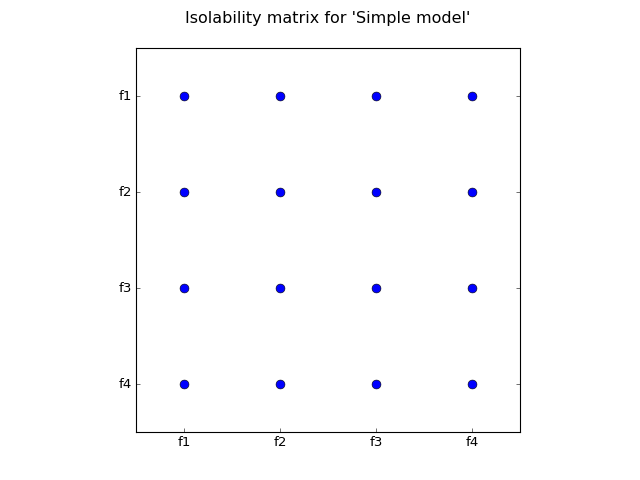

In [3]:
plt.figure(10)
model.IsolabilityAnalysis(plot=True);

Found 9 sensor sets
[['x1', 'x2', 'x4'], ['x1', 'x1', 'x4'], ['x1', 'x3', 'x4'], ['x1', 'x2', 'x3'], ['x1', 'x1', 'x3'], ['x2', 'x2', 'x4'], ['x2', 'x3', 'x4'], ['x2', 'x2', 'x3'], ['x3', 'x3', 'x4', 'x4']]


<IPython.core.display.Javascript object>


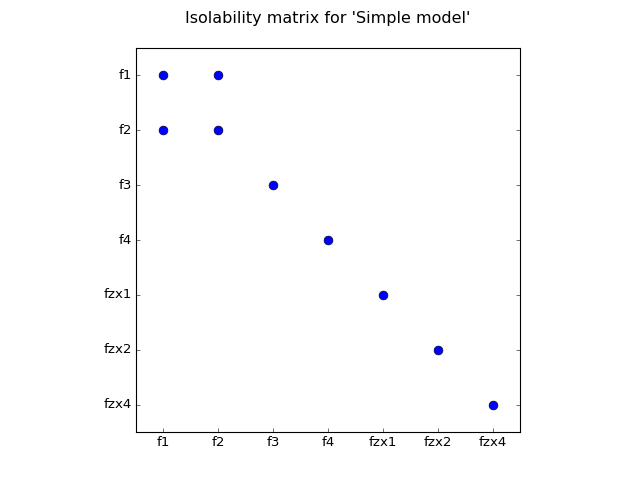

In [5]:
model2 = model.copy()
#model2.SensorLocationsWithFaults() # No faulty sensors
model2.SensorLocationsWithFaults(model.x) # All sensors may fail
sensSets,_ = model2.SensorPlacementIsolability()
print "Found " + str(len(sensSets)) + " sensor sets"
print sensSets
model2.AddSensors(sensSets[0])

plt.figure(20)
model2.IsolabilityAnalysis(plot=True);